In [9]:
from ase.io import read, write
from ase.data import atomic_masses, atomic_numbers

atoms = read("./distill_test/data/li3po4_192.xyz")
atoms = atoms * (13,13,13)
masses = [atomic_masses[atomic_numbers[s]] for s in atoms.get_chemical_symbols()]
atoms.set_masses(masses)
write(f"./distill_test/data/li3po4_{len(atoms)}.data", atoms, format="lammps-data", masses=True)

atoms = read(f"./distill_test/data/li3po4_{len(atoms)}.data", format="lammps-data")
print(atoms.get_cell())
print(len(atoms))

Cell([[139.4981155285769, 0.0, 0.0], [3.3628141579550954, 162.39223375027376, 0.0], [2.288725724713538, -1.3278675800432187, 197.41978551621727]])
421824


In [1]:
import ase.units as units

GPa_to_eV_A3 = units.GPa
# 例如：1 GPa = units.GPa eV/Å^3
print(GPa_to_eV_A3)      # ~0.0062415
print(1.0 / GPa_to_eV_A3)  # ~160.2177  (eV/Å^3 -> GPa 的倒数关系)

0.006241509125883258
160.21766208


In [9]:
import numpy as np
import copy

def perturb_cell_strain(
    lattice: np.ndarray,
    vol_sigma: float,
    shear_sigma: float,
    max_abs_strain: float,
    max_tries: int = 1000,
):
    """
    perturb cell: H'=(I+ε)H
    - vol_sigma: volumn change
    - shear_sigma: shear change
    - max_abs_strain: upper limit for main strain
    """
    H = copy.deepcopy(lattice)
    det0 = np.linalg.det(H)
    if det0 <= 0:
        raise ValueError("Input cell determinant must be positive.")
    I = np.eye(3)

    for _ in range(max_tries):
        dlogV = np.random.normal(0.0, vol_sigma)
        s = np.exp(dlogV / 3.0)
        eps_vol = (s - 1.0) * I

        A = np.random.normal(0.0, shear_sigma, size=(3, 3))
        eps = 0.5 * (A + A.T)
        eps -= np.trace(eps) / 3.0 * I

        eps_total = eps_vol + eps

        eps_total = np.clip(eps_total, -max_abs_strain, max_abs_strain)

        H_new = (I + eps_total) @ H

        det_new = np.linalg.det(H_new)
        if det_new <= 0:
            continue

        vol_ratio = det_new / det0
        if not (0.5 < vol_ratio < 2.0):
            continue

        return H_new

    raise RuntimeError(
        "Failed to generate a valid perturbed cell within max_tries. This should be abnormal, please check whether the input lattice is wrong")
    

voigt = np.random.randn(6) * 5
lattice = np.array([[voigt[0], voigt[1], voigt[2]], [voigt[1], voigt[3], voigt[4]], [voigt[2], voigt[4], voigt[5]]])
H_new = perturb_cell_strain(
    lattice = lattice,
    vol_sigma=0.05,
    shear_sigma =0.05,
    max_abs_strain=0.1
)
print(lattice)
print(H_new)


[[ 2.75783812 -0.41503282 -6.99170596]
 [-0.41503282 -0.38894473  0.54185439]
 [-6.99170596  0.54185439  5.65383495]]
[[ 2.72868182 -0.41179019 -7.25248126]
 [-0.42324879 -0.37428987  0.68867609]
 [-6.62984596  0.51203171  5.22112095]]


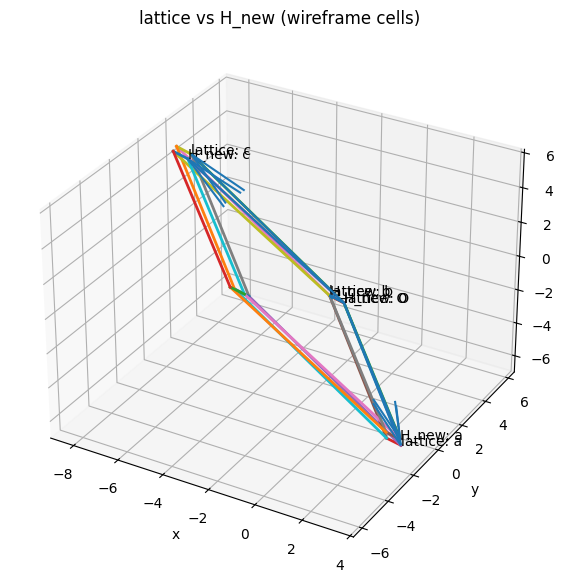

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def cell_vertices_from_cols(H: np.ndarray) -> np.ndarray:
    """Return the 8 vertices of the cell parallelepiped, treating columns as cell vectors."""
    a, b, c = H[:, 0], H[:, 1], H[:, 2]
    O = np.zeros(3)
    return np.array([O, a, b, c, a + b, a + c, b + c, a + b + c])

def draw_cell(ax, H: np.ndarray, label: str):
    """Draw a cell as a wireframe parallelepiped + basis arrows."""
    verts = cell_vertices_from_cols(H)

    # edges between the 8 vertices
    edges = [
        (0,1), (0,2), (0,3),
        (1,4), (1,5),
        (2,4), (2,6),
        (3,5), (3,6),
        (4,7), (5,7), (6,7),
    ]
    for i, j in edges:
        xs, ys, zs = zip(verts[i], verts[j])
        ax.plot(xs, ys, zs, linewidth=2)

    # basis vectors as arrows
    origin = np.zeros((3, 1))
    ax.quiver(
        origin[0], origin[1], origin[2],
        H[0], H[1], H[2],
        length=1.0, normalize=False
    )

    # labels for origin and basis
    ax.text(0, 0, 0, f"{label}: O")
    ax.text(H[0,0], H[1,0], H[2,0], f"{label}: a")
    ax.text(H[0,1], H[1,1], H[2,1], f"{label}: b")
    ax.text(H[0,2], H[1,2], H[2,2], f"{label}: c")

# --- visualize ---
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection="3d")

# If your cell vectors are rows, use lattice.T / H_new.T instead
draw_cell(ax, lattice, "lattice")
draw_cell(ax, H_new, "H_new")

ax.set_title("lattice vs H_new (wireframe cells)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# Make axes roughly equal scale
all_pts = np.vstack([cell_vertices_from_cols(lattice), cell_vertices_from_cols(H_new)])
mins = all_pts.min(axis=0)
maxs = all_pts.max(axis=0)
center = (mins + maxs) / 2.0
radius = (maxs - mins).max() / 2.0
ax.set_xlim(center[0] - radius, center[0] + radius)
ax.set_ylim(center[1] - radius, center[1] + radius)
ax.set_zlim(center[2] - radius, center[2] + radius)

plt.show()


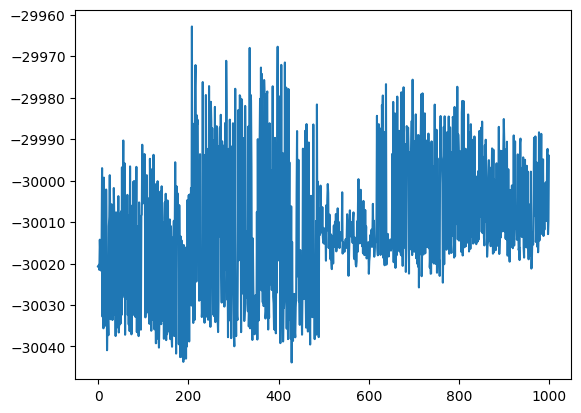

In [1]:
from ase import Atoms
from ase.io import read
import matplotlib.pyplot as plt

atoms_list: list[Atoms] = read("/nethome/lkong88/MatterTune/examples/water-thermodynamics/data/water_1000_eVAng.xyz", index=":")
energies = [atoms.get_potential_energy() for atoms in atoms_list]
plt.plot(energies)
plt.show()